In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk
from pandas.plotting import lag_plot

c:\Users\Admin\anaconda3\envs\quant\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed


Coefficient: 0.004525876526043777
Intercept: -0.03149997148664144
R2: 0.00


Price,Date,Close,High,Low,Open,Volume,Close + 1,Target,RSI,Predictions,residuals
13,2010-07-19,1.460667,1.483333,1.394667,1.424667,37297500,1.353333,-7.348288,43.408794,0.164963,7.513251
14,2010-07-20,1.353333,1.456667,1.336667,1.456667,27379500,1.348000,-0.394060,39.206237,0.145943,0.540003
15,2010-07-21,1.348000,1.393333,1.300000,1.377333,18787500,1.400000,3.857561,39.159154,0.145730,-3.711832
16,2010-07-22,1.400000,1.416667,1.358000,1.366667,14367000,1.419333,1.380929,46.915168,0.180832,-1.200097
17,2010-07-23,1.419333,1.437333,1.404000,1.412667,9804000,1.396667,-1.596946,57.983173,0.230925,1.827870
...,...,...,...,...,...,...,...,...,...,...,...
3926,2026-02-06,411.109985,414.549988,397.750000,400.869995,62677100,417.320007,1.510550,40.806793,0.153187,-1.357363
3927,2026-02-09,417.320007,421.250000,407.290009,409.910004,54484300,425.209991,1.890632,49.266107,0.191472,-1.699159
3928,2026-02-10,425.209991,427.250000,417.000000,418.079987,64450200,428.269989,0.719644,47.550903,0.183710,-0.535934
3929,2026-02-11,428.269989,436.350006,420.029999,427.959991,57362000,417.070007,-2.615168,40.612482,0.152307,2.767476


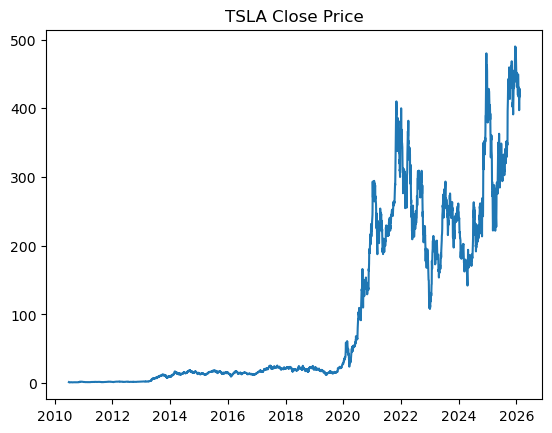

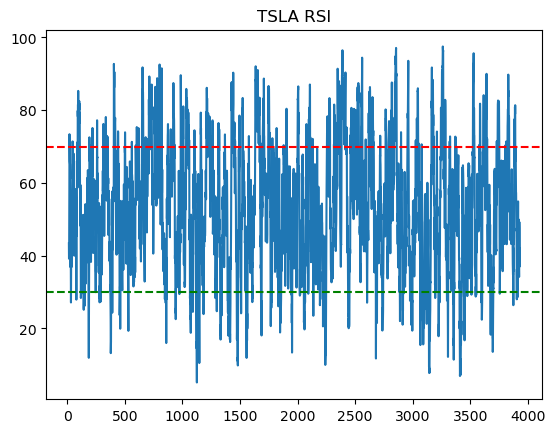

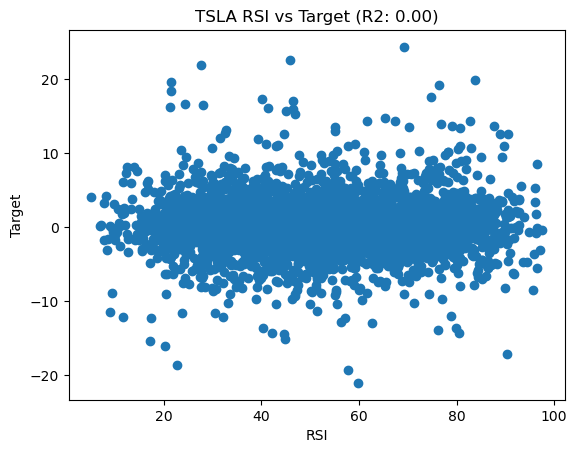

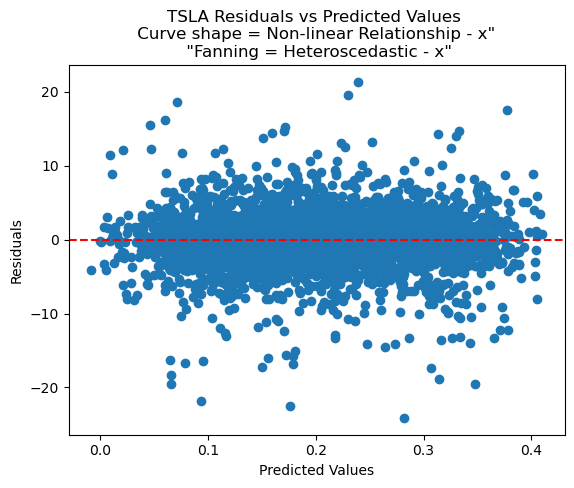

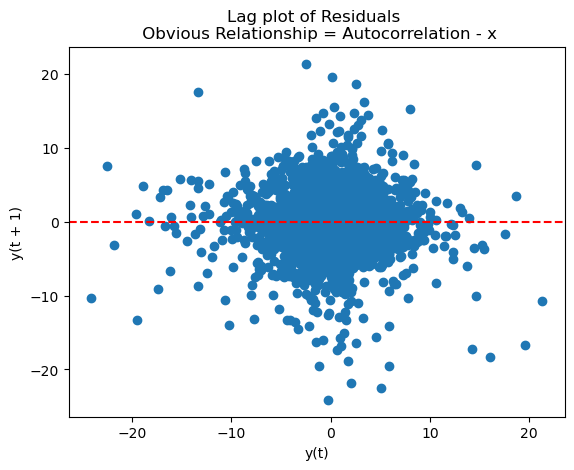

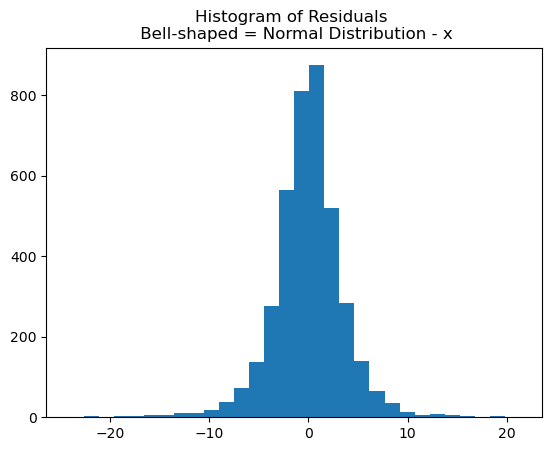

In [ ]:
ticker = "TSLA"
interval = '1d'

#set period based on interval
if interval == '1h':
    period = "max"
else:
    period = "max"

LOOKBACK = -5000
SHIFT=1
STRATEGY='RSI'

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

def get_data(ticker, lookback=LOOKBACK, interval=interval, period=period, auto_adjust=True):
    df = yf.download(ticker, period = period, auto_adjust=auto_adjust, interval=interval)
    #reset index to get datetime as a column
    plt.figure()
    plt.plot(df['Close'])
    plt.title(f'{ticker} Close Price')

    #plt.figure()
    #plt.plot(df['Adj Close'])
    #plt.title(f'{ticker} Adjusted Close Price')

    df = df.reset_index()

    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    #only return data after lookback
    return df.iloc[lookback:,:]

#define the target variable (also called dependent variable, or y )
def add_target(df, shift=SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    #what is the change in  close price SHIFT days from now?
    df['Target'] = ((df[f'Close + {shift}'] - df['Close']) / df['Close']) * 100
    return df

def add_RSI_feature(df, RSI_LENGTH):

    delta = df['Close'].diff()

    #separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    #calculate average gain and loss
    avg_gain = gain.rolling(window=RSI_LENGTH).mean()
    avg_loss = loss.rolling(window=RSI_LENGTH).mean()

    #calculate RSI
    rs = avg_gain / avg_loss 
    df['RSI'] = 100 - (100 / (1 + rs))

    #plot RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} RSI')

    return df.dropna()

def generate_regression_output(df, feature='RSI', target='Target'):
    
    subset = df[[feature,target]].dropna()

    # reshape for sklearn 
    x = subset[[feature]].dropna() #2d
    y = subset[target].dropna()  #1d

    model = sk.linear_model.LinearRegression()
    model.fit(x, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(x)

    #what is the relationhip btw features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # make coefficient variable
    coefficient = model.coef_[0]
    intercept = model.intercept_

    #coef, intercept, r2..... mse  later on
    print(f'Coefficient: {coefficient}')
    print(f'Intercept: {intercept}')
    print(f'R2: {r2:.2f}')

    #plot a relationship btw feature and target
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel(f'{feature}')
    plt.ylabel(f'{target}')
    plt.title(f'{ticker} {feature} vs {target} (R2: {r2:.2f})')

    return coefficient, intercept

def test_linearity_homoscedasticity(df, coef, intercept):
    # y = mx + c
    #info neccessary
    df['Predictions'] = df[STRATEGY] * coef + intercept
    df['residuals'] = df['Predictions'] - df['Target']

    #plot relationship
    plt.figure()
    plt.scatter(df['Predictions'], df['residuals'])
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{ticker} Residuals vs Predicted Values \n Curve shape = Non-linear Relationship - x" \n "Fanning = Heteroscedastic - x"')

    return df

def test_independence(df):

    plt.figure()
    lag_plot(df['residuals'].dropna())
    plt.title('Lag plot of Residuals \n Obvious Relationship = Autocorrelation - x')
    plt.axhline(0, color='red', linestyle='--')
    return

def validate_regression_output(df, coef, intercept):
    # y = mx + c
    #info neccessary
    #test_linearity_homoscedasticity
    df['Predictions'] = df[STRATEGY] * coef + intercept
    df['residuals'] = df['Predictions'] - df['Target']

    #plot relationship
    plt.figure()
    plt.scatter(df['Predictions'], df['residuals'])
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{ticker} Residuals vs Predicted Values \n Curve shape = Non-linear Relationship - x" \n "Fanning = Heteroscedastic - x"')

    #test_independence
    plt.figure()
    lag_plot(df['residuals'].dropna())
    plt.title('Lag plot of Residuals \n Obvious Relationship = Autocorrelation - x')
    plt.axhline(0, color='red', linestyle='--')

    #test_normality
    plt.figure()
    plt.hist(df['residuals'].dropna(), bins=30)
    plt.title('Histogram of Residuals \n Bell-shaped = Normal Distribution - x')
    return df
    
def test_normality(df):
    plt.figure()
    plt.hist(df['residuals'].dropna(), bins=30)
    plt.title('Histogram of Residuals \n Bell-shaped = Normal Distribution - x')
    return

def main():
    df = get_data(ticker, lookback=LOOKBACK, interval=interval, period=period)
    df = add_target(df, shift=SHIFT)
    df = add_RSI_feature(df, RSI_LENGTH=RSI_LENGTH)
    coef, intercept = generate_regression_output(df)
    df = test_linearity_homoscedasticity(df, coef=coef, intercept=intercept)
    test_independence(df)
    test_normality(df)
    return df

df = main()
df

(array([  64.,  281.,  609., 1013., 1170.,  792.,  678.,  298.,   71.,
          10.]),
 array([-0.07035566, -0.04414979, -0.01794393,  0.00826194,  0.0344678 ,
         0.06067366,  0.08687953,  0.11308539,  0.13929126,  0.16549712,
         0.19170299]),
 <BarContainer object of 10 artists>)

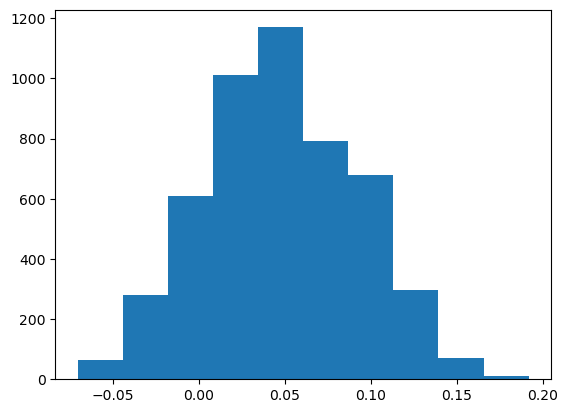

In [5]:
plt.hist(df['Predictions'])